In [1]:
import numpy as np
import pandas as pd
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

/home/enton/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
file1_path = 'inputs/nyc_listings.csv'
file2_path = 'inputs/nyc_reviews.csv'
selected1_cols = ['id', 'review_scores_rating']
selected2_cols = ['listing_id', 'comments']
df1 = pd.read_csv(file1_path, usecols=selected1_cols)
df2 = pd.read_csv(file2_path, usecols=selected2_cols)

In [3]:
df1.rename(columns={'id': 'listing_id'}, inplace=True)
df = pd.merge(df1, df2)
df.rename(columns={'listing_id': 'id'}, inplace=True)
df.rename(columns={'review_scores_rating': 'rating'}, inplace=True)
df.rename(columns={'comments': 'review'}, inplace=True)
new_cols = ['id', 'review', 'rating']
dfs = df[new_cols]
dfs.head()

,id,review,rating
0,21935608,Mike was very responsive and accommodating. Th...,4.67
1,21935608,I couldn’t be more satisfied with my stay at M...,4.67
2,21935608,Mike's space was absolutely lovely and in a wo...,4.67
3,21935608,The apartment was just exactly what I was look...,4.67
4,21935608,Mike and Zoe were great hosts. Mike wrote a ve...,4.67


In [4]:
dfs["rating"].value_counts()

rating
5.00    44881
4.88    33273
4.91    31278
4.93    29473
4.86    29133
        ...  
2.75        7
2.40        5
2.25        4
1.75        4
0.00        4
Name: count, Length: 163, dtype: int64

In [5]:
positive = [5]
negative = [1, 2]
neutral = [3, 4]

def sentiment(rating):
  if rating in positive:
    return 2
  elif rating in negative:
    return 0
  else:
    return 1
  
dfs['rating'] = dfs['rating'].round().astype(int)
dfs['target'] = dfs['rating'].apply(sentiment)

In [6]:
dfs.head()

,id,review,rating,target
0,21935608,Mike was very responsive and accommodating. Th...,5,2
1,21935608,I couldn’t be more satisfied with my stay at M...,5,2
2,21935608,Mike's space was absolutely lovely and in a wo...,5,2
3,21935608,The apartment was just exactly what I was look...,5,2
4,21935608,Mike and Zoe were great hosts. Mike wrote a ve...,5,2


In [7]:
dfs['message_len'] = dfs['review'].apply(lambda x: len(str(x).split(' ')))
print(max(dfs['message_len']))
dfs.head()

1029


,id,review,rating,target,message_len
0,21935608,Mike was very responsive and accommodating. Th...,5,2,79
1,21935608,I couldn’t be more satisfied with my stay at M...,5,2,54
2,21935608,Mike's space was absolutely lovely and in a wo...,5,2,35
3,21935608,The apartment was just exactly what I was look...,5,2,40
4,21935608,Mike and Zoe were great hosts. Mike wrote a ve...,5,2,92


In [8]:
dfs['target'].value_counts()

target
2    902842
1     98038
0       415
Name: count, dtype: int64

In [9]:
balance_counts = dfs.groupby('target')['target'].agg('count').values
balance_counts

array([   415,  98038, 902842])

In [10]:
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"
primary_green = px.colors.qualitative.Plotly[2]

In [11]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['0'],
    y=[balance_counts[0]],
    name='negative',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['1'],
    y=[balance_counts[1]],
    name='neutral',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.add_trace(go.Bar(
    x=['2'],
    y=[balance_counts[2]],
    name='positive',
    text=[balance_counts[2]],
    textposition='auto',
    marker_color=primary_blue
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [12]:
positive_df = dfs[dfs['target'] == 2]['message_len'].value_counts().sort_index()
neutral_df = dfs[dfs['target'] == 1]['message_len'].value_counts().sort_index()
negative_df = dfs[dfs['target'] == 0]['message_len'].value_counts().sort_index()
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=positive_df.index,
    y=positive_df.values,
    name='positive',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=neutral_df.index,
    y=neutral_df.values,
    name='neutral',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.add_trace(go.Scatter(
    x=negative_df.index,
    y=negative_df.values,
    name='negative',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

In [13]:
# text-processing function
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
dfs['review'] = dfs['review'].apply(clean_text)
dfs.head()

,id,review,rating,target,message_len
0,21935608,mike was very responsive and accommodating the...,5,2,79
1,21935608,i couldn’t be more satisfied with my stay at m...,5,2,54
2,21935608,mikes space was absolutely lovely and in a won...,5,2,35
3,21935608,the apartment was just exactly what i was look...,5,2,40
4,21935608,mike and zoe were great hosts mike wrote a ver...,5,2,92


In [15]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in str(text).split(' ') if word not in stop_words)
    return text
    
dfs['review'] = dfs['review'].apply(remove_stopwords)
dfs.head()

,id,review,rating,target,message_len
0,21935608,mike responsive accommodating apartment conven...,5,2,79
1,21935608,couldn’t satisfied stay mike’s airbnb apartmen...,5,2,54
2,21935608,mikes space absolutely lovely wonderful locati...,5,2,35
3,21935608,apartment exactly looking clean nearby everyth...,5,2,40
4,21935608,mike zoe great hosts mike wrote detailed messa...,5,2,92


In [16]:
stemmer = nltk.SnowballStemmer("english")

# all the text preprocessing in one function
def preprocess_data(text):
    # Clean puntuation, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in str(text).split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in str(text).split(' '))
    
    return text

In [17]:
dfs['review'] = dfs['review'].apply(preprocess_data)

In [18]:
dfs.head()

,id,review,rating,target,message_len
0,21935608,mike respons accommod apart conveni locat clos...,5,2,79
1,21935608,couldn't satisfi stay mike airbnb apart apart ...,5,2,54
2,21935608,mike space absolut love wonder locat stay plac...,5,2,35
3,21935608,apart exact look clean nearbi everyth want see...,5,2,40
4,21935608,mike zoe great host mike wrote detail messag c...,5,2,92


In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(dfs['target'])

dfs['target_encoded'] = le.transform(dfs['target'])
dfs.head()

,id,review,rating,target,message_len,target_encoded
0,21935608,mike respons accommod apart conveni locat clos...,5,2,79,2
1,21935608,couldn't satisfi stay mike airbnb apart apart ...,5,2,54,2
2,21935608,mike space absolut love wonder locat stay plac...,5,2,35,2
3,21935608,apart exact look clean nearbi everyth want see...,5,2,40,2
4,21935608,mike zoe great host mike wrote detail messag c...,5,2,92,2


In [20]:
#10k sample
X = dfs['review'][:1000]
y = dfs['target_encoded'][:1000]
len(X), len(y)

(1000, 1000)

In [21]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

750 750
250 250


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [23]:
# Use the trained to create a document-term matrix from train and test sets
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [24]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), 
                              min_df=0.1, max_df=0.7, max_features=100)

In [25]:
#tf-idf transform
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<750x3497 sparse matrix of type '<class 'numpy.float64'>'
	with 17226 stored elements in Compressed Sparse Row format>

In [26]:
texts = dfs['review'][:1000]
target = dfs['target_encoded'][:1000]

In [27]:
# Calculate the length of our vocabulary
from keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

2024-01-21 23:08:17.723328: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 23:08:18.016788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 23:08:18.016859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 23:08:18.067110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 23:08:18.171682: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 23:08:18.173239: I tensorflow/core/platform/cpu_feature_guard.cc:1

4293

In [28]:
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [29]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[ 382,   56,   63, ...,    0,    0,    0],
       [1296,  867,    2, ...,    0,    0,    0],
       [ 382,   48,  196, ...,    0,    0,    0],
       ...,
       [   4,    8,    5, ...,    0,    0,    0],
       [ 327,    1,   15, ...,    0,    0,    0],
       [ 302,   46, 4285, ...,    0,    0,    0]], dtype=int32)

### word embeddings with GloVe

In [30]:
embeddings_dictionary = dict()
embedding_dim = 300

# Load GloVe 300D embeddings
with open('inputs/glove6b/glove.6B.300d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [31]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.23188999, -0.19536   ,  0.033388  , ...,  0.11391   ,
         0.18514   , -0.36860001],
       [ 0.11001   , -0.065944  , -0.36711001, ..., -0.24947999,
        -0.40022001,  0.25386   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0409    ,  0.40770999, -0.5733    , ...,  0.20971   ,
         0.32211   , -0.54822999],
       [ 0.19982   , -0.07883   ,  0.1101    , ...,  0.62111998,
         0.040816  , -0.25703001]])

In [32]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [33]:
# Make class anf probability predictions
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [34]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))



0.796


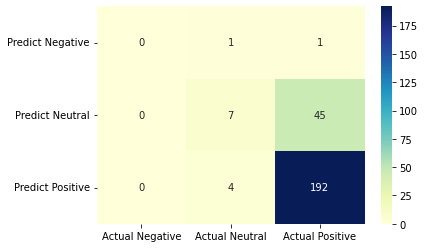

In [35]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
def conf_matrix():
    cm = confusion_matrix(y_test, y_pred_class)
    #print('Confusion matrix\n', cm)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative', 'Actual Neutral', 'Actual Positive'], 
                            index=['Predict Negative', 'Predict Neutral', 'Predict Positive'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()

conf_matrix()

In [36]:
# NAIVE BAYES
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

0.784


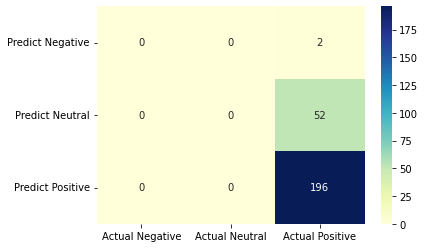

In [37]:
# Fit the pipeline with the data
pipe.fit(X_train, y_train)

y_pred_class = pipe.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix()

In [38]:
# XGBoost
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

Train: 0.9546666666666667
Test: 0.844


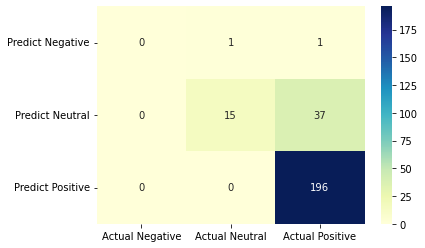

In [39]:
# Fit the pipeline with the data
pipe.fit(X_train, y_train)

y_pred_class = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix()

In [46]:
# LSTM
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

In [47]:
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 240, 300)          1287900   
                                                                 
 bidirectional_2 (Bidirecti  (None, 240, 480)          1038720   
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 480)               0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_2 (Bat  (None, 480)               1920      
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 480)               0         
                                                      

In [48]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
24/24 [==============================] - ETA: 0s - loss: -92.2495 - accuracy: 0.2067
Epoch 1: val_loss improved from inf to -204.30229, saving model to model.h5
24/24 [==============================] - 45s 2s/step - loss: -92.2495 - accuracy: 0.2067 - val_loss: -204.3023 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 2/7
24/24 [==============================] - ETA: 0s - loss: -1099.6331 - accuracy: 0.2120
Epoch 2: val_loss improved from -204.30229 to -1599.17102, saving model to model.h5
24/24 [==============================] - 40s 2s/step - loss: -1099.6331 - accuracy: 0.2120 - val_loss: -1599.1710 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 3/7
24/24 [==============================] - ETA: 0s - loss: -3773.0190 - accuracy: 0.2120
Epoch 3: val_loss improved from -1599.17102 to -4379.94287, saving model to model.h5
24/24 [==============================] - 39s 2s/step - loss: -3773.0190 - accuracy: 0.2120 - val_loss: -4379.9429 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 4/7
24/24 [==

In [49]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

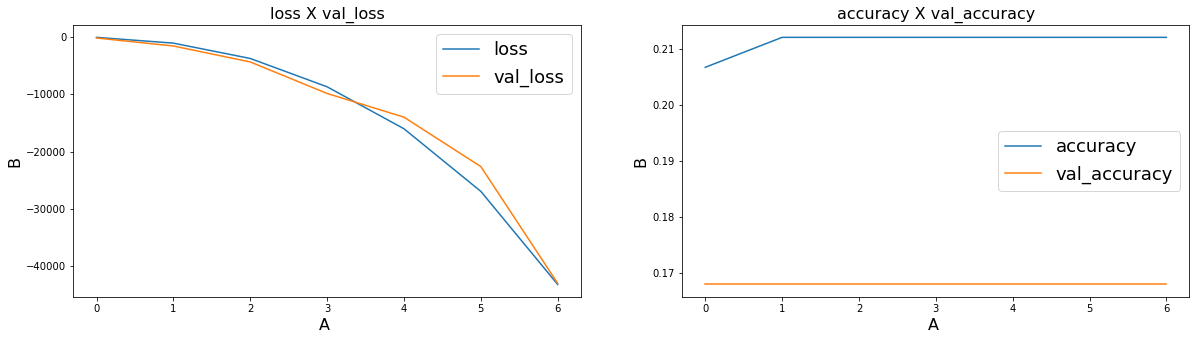

In [50]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [55]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")

8/8 [==============================] - 2s 270ms/step


### BeRT

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [57]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Number of replicas in sync: ', strategy.num_replicas_in_sync)

Number of replicas in sync:  1


In [58]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [60]:
texts = dfs['review'][:1000]
target = dfs['target_encoded'][:1000]

train_input_ids, train_attention_masks = bert_encode(texts,60)

/home/enton/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [61]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [62]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

2024-01-21 23:40:19.887665: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-01-21 23:40:20.026917: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-01-21 23:40:20.054970: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-01-21 23:40:21.672750: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-01-21 23:40:21.813200: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.t

In [63]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 60, 76                                           
                             8),                                                              

In [64]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
80/80 [==============================] - 346s 4s/step - loss: -113.4091 - accuracy: 0.1850 - val_loss: -232.9541 - val_accuracy: 0.2650
Epoch 2/3
80/80 [==============================] - 308s 4s/step - loss: -490.4615 - accuracy: 0.1850 - val_loss: -700.1987 - val_accuracy: 0.2650
Epoch 3/3
80/80 [==============================] - 314s 4s/step - loss: -1176.5535 - accuracy: 0.1850 - val_loss: -1445.2114 - val_accuracy: 0.2650


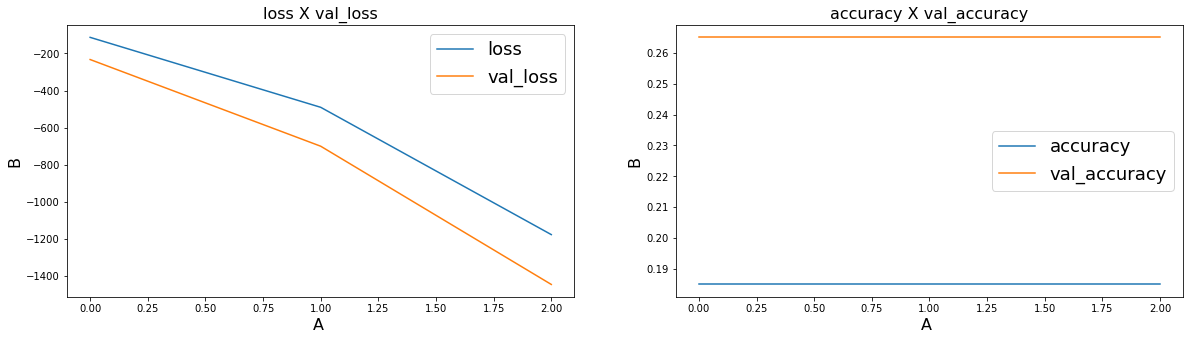

In [65]:
plot_learning_curves(history, [['loss', 'val_loss'],
                               ['accuracy', 'val_accuracy']])